# Regression Modeling Exercises

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, kruskal


from env import user, password, host
import acquire
import prepare
import explore
import model

In [2]:
# Calling my acquire function and assigning the output to df
df = acquire.wrangle_zillow()

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from env import user, password, host
 
def handle_nulls(df):    
    # We keep 99.41% of the data after dropping nulls
    # round(df.dropna().shape[0] / df.shape[0], 4) returned .9941
    df = df.dropna()
    return df


def optimize_types(df):
    # Convert some columns to integers for optimization
    # fips, yearbuilt, and bedrooms, taxvaluedollarcnt, and calculatedfinishedsquarefeet can be integers
    df["fips"] = df["fips"].astype(int)
    df["yearbuilt"] = df["yearbuilt"].astype(int)
    df["bedroomcnt"] = df["bedroomcnt"].astype(int)    
    df["taxvaluedollarcnt"] = df["taxvaluedollarcnt"].astype(int)
    df["calculatedfinishedsquarefeet"] = df["calculatedfinishedsquarefeet"].astype(int)
    return df


def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for 99% of buyers and zillow visitors"""
    df = df[df.bathroomcnt <= 6]
    
    df = df[df.bedroomcnt <= 6]

    df = df[df.taxvaluedollarcnt < 1_500_000]

    return df

def clean_variables(df):
    # Drop 'taxamount' column (variable is inconsistent based on time and location of collected value, could lead to poor analysis)
    # Rename columns and 'fips' values to reflect actual location (to solidify column as categorical variable)
    df = df.drop(columns = 'taxamount')
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'sq_ft', 
                              'taxvaluedollarcnt':'home_value', 
                              'yearbuilt':'year_built', 
                              'fips':'location',
                              'fullbathcnt':'full_bathrooms',
                              'garagecarcnt':'garage_spaces',
                              'lotsizesquarefeet':'lot_sq_ft'
                             })
    df.location = df.location.replace(to_replace={6037:'LA County', 6059:'Orange County', 6111:'Ventura County'})

    return df 

def feature_engineering(df):
    # Bin `year_built` by decade
    df["decade_built"] = pd.cut(x=df["year_built"], bins=[1800, 1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009], labels=['1800s', '1900s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '2000s'])
    # Convert categorical variable to numeric var
    df['county_encoded'] = df.location.map({'LA County': 0, 'Orange County': 1, 'Ventura County': 2})

    df = df.dropna()

    return df

# Split for Exploration

## 
# Train, Validate, Test Split Function: for exploration
def zillow_split_explore(df):
    '''
    This function performs split on telco data, stratifying on churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2,
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3,
                                   random_state=123)
    return train, validate, test

### ------------------------------------------------------------------------

# Split for Modeling: X & Y dfs
def zillow_split_model(df):
    '''
    This function performs split on telco data, stratifying on churn.
    Returns both X and y train, validate, and test dfs
    '''
    
    train_validate, test = train_test_split(df, test_size=.2,
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3,
                                   random_state=123)

    # Splitting train, validate, and test dfs on x and y
    x_train = train.drop(columns=['home_value'])
    x_validate = validate.drop(columns=['home_value'])
    x_test = test.drop(columns=['home_value'])

    y_train = train['home_value']
    y_validate = validate['home_value']
    y_test = test['home_value']
    
    return x_train, y_train, x_validate, y_validate, x_test, y_test


def prep_zillow(df):
    """
    Handles nulls
    optimizes or fixes data types
    handles outliers w/ manual logic
    clean variables via dropping columns and renaming features
    includes feature engineering 
    returns a clean dataframe
    Splits df into train, validate, test, and associated dfs on x and y 
    """
    df = handle_nulls(df)

    df = optimize_types(df)

    df = handle_outliers(df)

    df = clean_variables(df)

    df = feature_engineering(df)

    train, validate, test = zillow_split_explore(df)

    x_train, y_train, x_validate, y_validate, x_test, y_test = zillow_split_model(df)

    # df.to_csv("zillow.csv", index=False)

    return df, train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test

In [4]:
df, train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test = prep_zillow(df)

In [5]:
from sklearn.preprocessing import MinMaxScaler
#Define function to scale all data based on the train subset
def scale_data(train, validate, test):
    
    scale_columns = ['bedrooms', 'bathrooms', 'sq_ft']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    mms = MinMaxScaler()
    
    mms.fit(train[scale_columns])
    
    train_scaled[scale_columns] = mms.transform(train[scale_columns])
    validate_scaled[scale_columns] = mms.transform(validate[scale_columns])
    test_scaled[scale_columns] = mms.transform(test[scale_columns])
    
    return train_scaled, validate_scaled, test_scaled

In [6]:
# Calling our model.py; Assigning df variables to our called function, `scale_data`
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)

In [7]:
# Dropping extraneous features no longer relevant to modeling
train_scaled = train_scaled.drop(columns = ['location', 'decade_built'])
validate_scaled = validate_scaled.drop(columns = ['location', 'decade_built'])
test_scaled = test_scaled.drop(columns = ['location', 'decade_built'])

In [8]:
# Splitting train, validate, and test dfs on x and y FOR SCALED DF
x_train_scaled = train_scaled.drop(columns=['home_value'])
x_validate_scaled = validate_scaled.drop(columns=['home_value'])
x_test_scaled = test_scaled.drop(columns=['home_value'])

y_train_scaled = train_scaled['home_value']
y_validate_scaled = validate_scaled['home_value']
y_test_scaled = test_scaled['home_value']

### Begin Modeling

#### Baseline

In [9]:
#Establish baselines for the train and validation datasets
baseline = train['home_value'].mean()

In [10]:
train['baseline'] = baseline
validate['baseline'] = baseline
test['baseline'] = baseline

In [11]:
train_rmse = sqrt(mean_squared_error(train['home_value'], train.baseline))
validate_rmse = sqrt(mean_squared_error(validate['home_value'], validate.baseline))
test_rmse = sqrt(mean_squared_error(test['home_value'], test.baseline))

In [12]:
print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))
print('Test baseline RMSE: {}.'.format(test_rmse))

Train baseline RMSE: 269907.8380289604.
Validation baseline RMSE: 271021.9790555932.
Test baseline RMSE: 269541.2621903645.


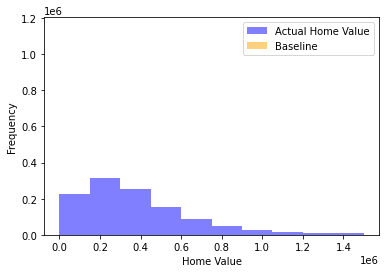

In [13]:
#Plot my train baseline against the actual home_value distribution
plt.hist(train['home_value'], color='blue', alpha=0.5, label='Actual Home Value')
plt.hist(train.baseline, color='orange', alpha=0.5, label='Baseline')
plt.xlabel('Home Value')
plt.ylabel('Frequency')
plt.legend()

In [14]:
train_predictions = pd.DataFrame({
    'actual': train['home_value'],
    'baseline': baseline
}) 

train_predictions.head()

predictions = pd.DataFrame({
    'actual': validate['home_value'],
    'baseline': baseline
}) 

In [15]:
predictions.head()

,actual,baseline
1953946,380718,376327.765369
920890,211774,376327.765369
105171,293112,376327.765369
54562,23561,376327.765369
960127,383054,376327.765369


#### Fitting Linear Regression

In [16]:
x_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146837 entries, 1779084 to 955507
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   bedrooms        1146837 non-null  float64
 1   bathrooms       1146837 non-null  float64
 2   sq_ft           1146837 non-null  float64
 3   year_built      1146837 non-null  int64  
 4   county_encoded  1146837 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 52.5 MB


In [17]:
#Create an instance of the model and fit it to my data
lm = LinearRegression().fit(x_train_scaled, y_train_scaled)

In [18]:
train_predictions['simple_lm'] = lm.predict(x_train_scaled)
predictions['simple_lm'] = lm.predict(x_validate_scaled)

In [19]:
train_predictions.head()

,actual,baseline,simple_lm
1779084,680993,376327.765369,669764.947416
630679,109930,376327.765369,361612.605705
611984,342551,376327.765369,347925.439986
388401,294687,376327.765369,373113.848281
680564,456245,376327.765369,505373.146285


In [20]:
predictions.head()

,actual,baseline,simple_lm
1953946,380718,376327.765369,188223.804656
920890,211774,376327.765369,455180.726151
105171,293112,376327.765369,381808.695194
54562,23561,376327.765369,183800.344563
960127,383054,376327.765369,486463.948436


#### Fitting Lasso-Lars Regression

In [21]:
# Starting at alpha = 1.0

# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(x_train_scaled, y_train_scaled)

# predict train
train_predictions['lasso_lars_a_1'] = lars.predict(x_train_scaled)

# predict validate
predictions['lasso_lars_a_1'] = lars.predict(x_validate_scaled)

In [22]:
# alpha = 0.5

# create the model object
lars = LassoLars(alpha=0.5)

# fit the model to our training data
lars.fit(x_train_scaled, y_train_scaled)

# predict train
train_predictions['lasso_lars_a_05'] = lars.predict(x_train_scaled)

# predict validate
predictions['lasso_lars_a_05'] = lars.predict(x_validate_scaled)

In [23]:
# alpha = 2

# create the model object
lars = LassoLars(alpha=2)

# fit the model to our training data
lars.fit(x_train_scaled, y_train_scaled)

# predict train
train_predictions['lasso_lars_a_2'] = lars.predict(x_train_scaled)

# predict validate
predictions['lasso_lars_a_2'] = lars.predict(x_validate_scaled)

In [24]:
train_predictions.head()

,actual,baseline,simple_lm,lasso_lars_a_1,lasso_lars_a_05,lasso_lars_a_2
1779084,680993,376327.765369,669764.947416,667971.229140,668868.088278,666177.510864
630679,109930,376327.765369,361612.605705,360667.086566,361139.846135,359721.567427
611984,342551,376327.765369,347925.439986,348325.067327,348125.253657,348724.694668
388401,294687,376327.765369,373113.848281,369817.000195,371465.424238,366520.152109
680564,456245,376327.765369,505373.146285,504959.544395,505166.345340,504545.942505


In [25]:
predictions.head()

,actual,baseline,simple_lm,lasso_lars_a_1,lasso_lars_a_05,lasso_lars_a_2
1953946,380718,376327.765369,188223.804656,191665.053713,189944.429185,195106.302770
920890,211774,376327.765369,455180.726151,451742.155629,453461.440890,448303.585108
105171,293112,376327.765369,381808.695194,378505.204237,380156.949715,375201.713281
54562,23561,376327.765369,183800.344563,187286.362799,185543.353681,190772.381035
960127,383054,376327.765369,486463.948436,489977.327740,488220.638088,493490.707044


#### Fitting TweediRegressor (Generalized Linear Model, GLM)

In [26]:
# Start with power = 0 (assuming Normal Distribution)
# create the model object
##### why is alpha=1 ???????
glm = TweedieRegressor(power=0, alpha=1)

# fit the model to our training data
glm.fit(x_train_scaled, y_train_scaled)

# predict train, add to df
train_predictions['glm_p_0'] = glm.predict(x_train_scaled)

# predict validate, add to df
predictions['glm_p_0'] = glm.predict(x_validate_scaled)

In [27]:
# Now assuming Poisson Distribution, power = 1
# create the model object
glm = TweedieRegressor(power=1, alpha=1)

# fit the model to our training data
glm.fit(x_train_scaled, y_train_scaled)

# predict train, add to df
train_predictions['glm_p_1'] = glm.predict(x_train_scaled)

# predict validate, add to df
predictions['glm_p_1'] = glm.predict(x_validate_scaled)

In [28]:
train_predictions.head()

,actual,baseline,simple_lm,lasso_lars_a_1,lasso_lars_a_05,lasso_lars_a_2,glm_p_0,glm_p_1
1779084,680993,376327.765369,669764.947416,667971.229140,668868.088278,666177.510864,508270.935914,376327.765369
630679,109930,376327.765369,361612.605705,360667.086566,361139.846135,359721.567427,492273.272855,376327.765369
611984,342551,376327.765369,347925.439986,348325.067327,348125.253657,348724.694668,351311.923031,376327.765369
388401,294687,376327.765369,373113.848281,369817.000195,371465.424238,366520.152109,360099.346820,376327.765369
680564,456245,376327.765369,505373.146285,504959.544395,505166.345340,504545.942505,475728.614104,376327.765369


In [29]:
train_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146837 entries, 1779084 to 955507
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   actual           1146837 non-null  int64  
 1   baseline         1146837 non-null  float64
 2   simple_lm        1146837 non-null  float64
 3   lasso_lars_a_1   1146837 non-null  float64
 4   lasso_lars_a_05  1146837 non-null  float64
 5   lasso_lars_a_2   1146837 non-null  float64
 6   glm_p_0          1146837 non-null  float64
 7   glm_p_1          1146837 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 78.7 MB


In [30]:
predictions.head()

,actual,baseline,simple_lm,lasso_lars_a_1,lasso_lars_a_05,lasso_lars_a_2,glm_p_0,glm_p_1
1953946,380718,376327.765369,188223.804656,191665.053713,189944.429185,195106.302770,342678.338808,376327.765369
920890,211774,376327.765369,455180.726151,451742.155629,453461.440890,448303.585108,437497.416706,376327.765369
105171,293112,376327.765369,381808.695194,378505.204237,380156.949715,375201.713281,459320.369677,376327.765369
54562,23561,376327.765369,183800.344563,187286.362799,185543.353681,190772.381035,352512.833998,376327.765369
960127,383054,376327.765369,486463.948436,489977.327740,488220.638088,493490.707044,411212.322801,376327.765369


In [31]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491502 entries, 1953946 to 1865992
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   actual           491502 non-null  int64  
 1   baseline         491502 non-null  float64
 2   simple_lm        491502 non-null  float64
 3   lasso_lars_a_1   491502 non-null  float64
 4   lasso_lars_a_05  491502 non-null  float64
 5   lasso_lars_a_2   491502 non-null  float64
 6   glm_p_0          491502 non-null  float64
 7   glm_p_1          491502 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 33.7 MB


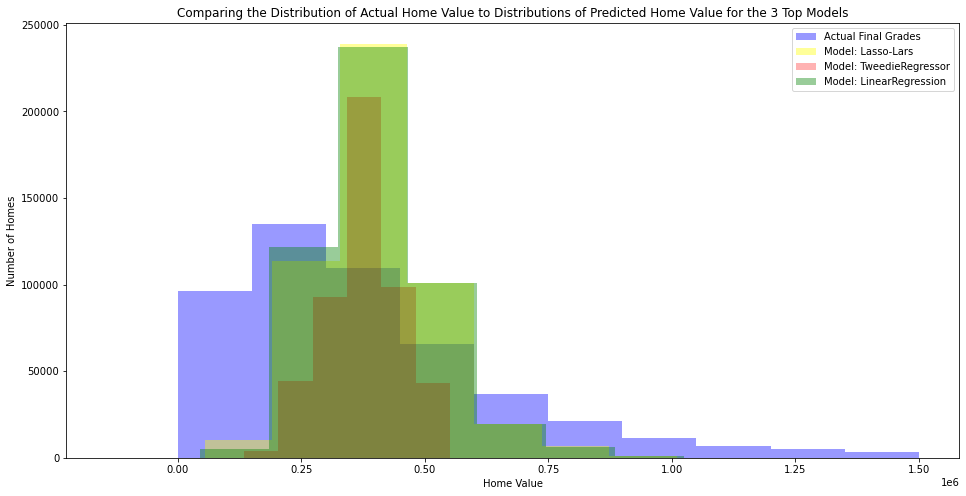

In [32]:
# Plot visualizing Actual Home Value vs Predicted Home Value on 3 Best Models 
plt.figure(figsize=(16,8))
plt.hist(predictions.actual, color='blue', alpha=.4, label="Actual Final Grades")
plt.hist(predictions.lasso_lars_a_1, color='yellow', alpha=0.4, label="Model: Lasso-Lars")
plt.hist(predictions.glm_p_0, color='red', alpha=.3, label="Model: TweedieRegressor")
plt.hist(predictions.simple_lm, color='green', alpha=.4, label="Model: LinearRegression")
plt.xlabel("Home Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Home Value to Distributions of Predicted Home Value for the 3 Top Models")
plt.legend()
plt.show()

In [33]:
# Modeling Evaluation

In [34]:
# Calculate mean squared error for every column in the train_predictions df
def calculate_mse(y_predicted):
    return mean_squared_error(train_predictions.actual, y_predicted)

print('Train baseline MSE: {}.'.format(train_rmse))
train_predictions.apply(calculate_mse).sort_values()

Train baseline MSE: 269907.8380289604.


actual             0.000000e+00
simple_lm          5.512504e+10
lasso_lars_a_05    5.512712e+10
lasso_lars_a_1     5.513334e+10
lasso_lars_a_2     5.515824e+10
glm_p_0            6.727295e+10
baseline           7.285024e+10
glm_p_1            7.285024e+10
dtype: float64

In [35]:
# Calculate mean squared error for every column in the predictions df
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

print('Validation baseline MSE: {}.'.format(validate_rmse))
predictions.apply(calculate_mse).sort_values()

Validation baseline MSE: 271021.9790555932.


actual             0.000000e+00
simple_lm          5.480599e+10
lasso_lars_a_05    5.483080e+10
lasso_lars_a_1     5.485948e+10
lasso_lars_a_2     5.492850e+10
glm_p_0            6.789212e+10
baseline           7.345291e+10
glm_p_1            7.345291e+10
dtype: float64

In [36]:
# Calculate root mean squared error (RMSE) for every column in the train_predictions df
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(train_predictions.actual, y_predicted))

print('Train baseline RMSE: {}.'.format(train_rmse))
train_predictions.apply(calculate_rmse).sort_values()

Train baseline RMSE: 269907.8380289604.


actual                  0.000000
simple_lm          234787.226784
lasso_lars_a_05    234791.644945
lasso_lars_a_1     234804.898927
lasso_lars_a_2     234857.907378
glm_p_0            259370.285719
baseline           269907.838029
glm_p_1            269907.838029
dtype: float64

In [37]:
# Calculate root mean squared error (RMSE) for every column in the predictions df
def calculate_rmse(y_predicted):
    return sqrt(mean_squared_error(predictions.actual, y_predicted))

print('Validation baseline RMSE: {}.'.format(validate_rmse))
predictions.apply(calculate_rmse).sort_values()

Validation baseline RMSE: 271021.9790555932.


actual                  0.000000
simple_lm          234106.786195
lasso_lars_a_05    234159.768127
lasso_lars_a_1     234221.017186
lasso_lars_a_2     234368.289887
glm_p_0            260561.166078
baseline           271021.979056
glm_p_1            271021.979056
dtype: float64